In [332]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 
import re
import datetime

In [466]:
#read excel sheet
xls = pd.ExcelFile('../../AI-ML Tractor Analytics/DataSet.xlsx')
sales = pd.read_excel(xls,'Sales Data')
historic = pd.read_excel(xls,'HISTORY_DAY')
climatology = pd.read_excel(xls,'CLIMATOLOGY_DAY')
forecast = pd.read_excel(xls,'FORECAST_DAY')

In [467]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [468]:
class Logger: 
    file = None
    def __init__(self,file):
        self.file = open(file,"a")
        self.file.write("--------------------NEW LOG--------------------\n")
        self.file.write("Logger started at: "+self.timestamp()+"\n")
        
    def log(self,message):
        self.file.write(message+"\n")
    
    def timestamp(self):
        stamp = datetime.datetime.now()
        year = str(stamp.year)
        month = str(stamp.month)
        day = str(stamp.day)
        hour = str(stamp.hour)
        minute = str(stamp.minute)
        seconds = str(stamp.second)
        
        return year+"-"+month+"-"+day+" "+hour+":"+minute+":"+seconds
        
    def stop(self):
        self.file.close()

In [469]:
def RMSE(data_predict,dataY_plot):
    c = 0
    for i in range(len(data_predict)):
        c = c + abs(data_predict[i][0] - dataY_plot[i][0]) ** 2
    
    return (c ** 0.5)/len(data_predict)

In [470]:
def dataloader(X,y,batch_size=4):
    loader = list()
    points = len(X)
    
    i = 0
    end = i + batch_size
    batch = dict()
    
    batch["data"] = X[i:end]
    batch["output"] = y[i:end]
    loader.append(batch)
    
    while end < points:
        i = i + batch_size
        end = i + batch_size
        
        
        batch = dict()
        batch["data"] = X[i:end]
        batch["output"] = y[i:end]
        
        loader.append(batch)
    
    return loader

In [471]:
forecast_columns = [
    'SCRUB_STORE_NO',
    'DATE_VALID_STD',
    'DOY_STD',
    'AVG_TEMPERATURE_AIR_2M_F',
    'AVG_TEMPERATURE_WETBULB_2M_F',
    'AVG_TEMPERATURE_DEWPOINT_2M_F',
    'AVG_TEMPERATURE_FEELSLIKE_2M_F',
    'AVG_HUMIDITY_RELATIVE_2M_PCT',
    'AVG_HUMIDITY_SPECIFIC_2M_GPKG',
    'AVG_PRESSURE_2M_MB',
    'AVG_PRESSURE_MEAN_SEA_LEVEL_MB',
    'AVG_WIND_SPEED_10M_MPH',
    'AVG_WIND_DIRECTION_10M_DEG',
    'AVG_WIND_DIRECTION_80M_DEG',
    'AVG_WIND_DIRECTION_100M_DEG',
    'TOT_PRECIPITATION_IN',
    'TOT_SNOWFALL_IN',
    'AVG_CLOUD_COVER_TOT_PCT',
    'AVG_RADIATION_SOLAR_TOTAL_WPM2',
    'TOT_RADIATION_SOLAR_TOTAL_WPM2'
]

In [472]:
historic_columns = [
    'SCRUB_STORE_NO',
    'DATE_VALID_STD',
    'DOY_STD',
    'AVG_TEMPERATURE_AIR_2M_F',
    'AVG_TEMPERATURE_WETBULB_2M_F',
    'AVG_TEMPERATURE_DEWPOINT_2M_F',
    'AVG_TEMPERATURE_FEELSLIKE_2M_F',
    'AVG_HUMIDITY_RELATIVE_2M_PCT',
    'AVG_HUMIDITY_SPECIFIC_2M_GPKG',
    'AVG_PRESSURE_2M_MB',
    'AVG_PRESSURE_MEAN_SEA_LEVEL_MB',
    'AVG_WIND_SPEED_10M_MPH',
    'AVG_WIND_DIRECTION_10M_DEG',
    'AVG_WIND_DIRECTION_80M_DEG',
    'AVG_WIND_DIRECTION_100M_DEG',
    'TOT_PRECIPITATION_IN',
    'TOT_SNOWFALL_IN',
    'AVG_CLOUD_COVER_TOT_PCT',
    'AVG_RADIATION_SOLAR_TOTAL_WPM2',
    'TOT_RADIATION_SOLAR_TOTAL_WPM2'
]

In [473]:
climatology_columns = [
    'SCRUB_STORE_NO',
    'COUNTRY',
    'DOY_STD',
    'AVG_OF__DAILY_AVG_TEMPERATURE_AIR_F',
    'AVG_OF__DAILY_AVG_TEMPERATURE_WETBULB_F',
    'AVG_OF__DAILY_AVG_TEMPERATURE_DEWPOINT_F',
    'AVG_OF__DAILY_AVG_TEMPERATURE_FEELSLIKE_F',
    'AVG_OF__DAILY_AVG_HUMIDITY_RELATIVE_PCT',
    'AVG_OF__DAILY_AVG_HUMIDITY_SPECIFIC_GPKG',
    'AVG_OF__DAILY_AVG_PRESSURE_SURFACE_MB',
    'AVG_OF__DAILY_AVG_PRESSURE_MEAN_SEA_LEVEL_MB',
    'AVG_OF__DAILY_AVG_WIND_SPEED_10M_MPH',
    'AVG_VEC_OF__DAILY_AVG_VEC_WIND_DIRECTION_10M_DEG',
    'AVG_VEC_OF__DAILY_AVG_VEC_WIND_DIRECTION_80M_DEG',
    'AVG_VEC_OF__DAILY_AVG_VEC_WIND_DIRECTION_100M_DEG',
    'AVG_OF__POS_DAILY_TOT_PRECIPITATION_IN',
    'AVG_OF__POS_DAILY_TOT_SNOWFALL_IN',
    'AVG_OF__DAILY_AVG_CLOUD_COVER_TOT_PCT',
    'AVG_OF__DAILY_AVG_RADIATION_SOLAR_TOTAL_WPM2',
    'AVG_OF__DAILY_TOT_RADIATION_SOLAR_TOTAL_WPM2'
]

In [498]:
forecast_dataset = forecast.copy()
forecast_dataset = forecast_dataset[forecast_columns]

historic_dataset = historic.copy()
historic_dataset = historic_dataset[historic_columns].copy()

climatology_dataset = climatology.copy()
climatology_dataset = climatology_dataset[climatology_columns].copy()

sales_dataset = sales.copy()

In [499]:
temp = historic_dataset.copy()

rows = historic_dataset.shape[0]
vals = list()

for i in range(rows):
    s = str(temp["SCRUB_STORE_NO"][i])
    s = s + "-" + str(temp["DOY_STD"][i])
    
    vals.append(s)

historic_dataset["h_c_id"] = vals

In [500]:
temp = climatology_dataset.copy()

rows = climatology_dataset.shape[0]
vals = list()

for i in range(rows):
    s = str(temp["SCRUB_STORE_NO"][i])
    s = s + "-" + str(temp["DOY_STD"][i])
    
    vals.append(s)

climatology_dataset["h_c_id"] = vals

In [501]:
merged_hc = historic_dataset.merge(climatology_dataset.drop(["SCRUB_STORE_NO","DOY_STD"],axis=1), on="h_c_id", how="left")

In [502]:
merged_hc = merged_hc.drop("h_c_id",axis=1)

In [503]:
temp = merged_hc.copy()

rows = merged_hc.shape[0]
vals = list()

for i in range(rows):
    s = "".join(str(temp["DATE_VALID_STD"][i]).split()[0].split("-"))
    s = s + "-" + str(temp["SCRUB_STORE_NO"][i])
    
    vals.append(s)

merged_hc["h_c_id"] = vals

In [504]:
temp = sales_dataset.copy()

rows = sales_dataset.shape[0]
vals = list()

for i in range(rows):
    s = str(temp["TIME_DIM_KEY"][i])
    s = s + "-" + str(temp["SCRUB_STORE_NO"][i])
    
    vals.append(s)

sales_dataset["h_c_id"] = vals

In [505]:
dataset = sales_dataset.merge(merged_hc.drop(["SCRUB_STORE_NO"],axis=1), on="h_c_id", how="left")

In [506]:
dataset = dataset.drop(["h_c_id","COUNTRY"],axis=1)

In [510]:
dataset.to_csv("./datasets/merged.csv",index=False)

In [286]:
final_data = dataset.copy()
for i in range(5,22):
    col = list(dataset.columns)[i]
    final_data[col] = dataset.iloc[:,i:i+1].to_numpy() - dataset.iloc[:,i+17:i+18].to_numpy()

In [287]:
final_data = final_data.iloc[:,:22]

In [313]:
final_data_columns = [
    'SALES_UNITS',
    'DATE_VALID_STD',
    'SCRUB_STORE_NO',
    'TIME_DIM_KEY',
    'DOY_STD',
    'AVG_TEMPERATURE_AIR_2M_F',
    'AVG_TEMPERATURE_WETBULB_2M_F',
    'AVG_TEMPERATURE_DEWPOINT_2M_F',
    'AVG_TEMPERATURE_FEELSLIKE_2M_F',
    'AVG_HUMIDITY_RELATIVE_2M_PCT',
    'AVG_HUMIDITY_SPECIFIC_2M_GPKG',
    'AVG_PRESSURE_2M_MB',
    'AVG_PRESSURE_MEAN_SEA_LEVEL_MB',
    'AVG_WIND_SPEED_10M_MPH',
    'AVG_WIND_DIRECTION_10M_DEG',
    'AVG_WIND_DIRECTION_80M_DEG',
    'AVG_WIND_DIRECTION_100M_DEG',
    'TOT_PRECIPITATION_IN',
    'TOT_SNOWFALL_IN',
    'AVG_CLOUD_COVER_TOT_PCT',
    'AVG_RADIATION_SOLAR_TOTAL_WPM2',
    'TOT_RADIATION_SOLAR_TOTAL_WPM2'
]

In [314]:
final_data = final_data[final_data_columns]

_____STORE NUM. 1_____
Training Shape torch.Size([1309, 1, 19]) torch.Size([1309, 1])
Testing Shape torch.Size([327, 1, 19]) torch.Size([327, 1])
Validation Loss Decreased(inf--->0.01539) 	 Saving The Model
Validation Loss Decreased(0.01539--->0.01373) 	 Saving The Model
Validation Loss Decreased(0.01373--->0.01321) 	 Saving The Model
Validation Loss Decreased(0.01321--->0.01291) 	 Saving The Model
Validation Loss Decreased(0.01291--->0.01286) 	 Saving The Model
Validation Loss Decreased(0.01286--->0.01280) 	 Saving The Model
Validation Loss Decreased(0.01280--->0.01258) 	 Saving The Model
Validation Loss Decreased(0.01258--->0.01243) 	 Saving The Model
Validation Loss Decreased(0.01243--->0.01204) 	 Saving The Model
Validation Loss Decreased(0.01204--->0.01199) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00189 		 Validation Loss: 0.01696
Epoch 200 		 Training Loss: 0.00086 		 Validation Loss: 0.01792
Epoch 300 		 Training Loss: 0.00079 		 Validation Loss: 0.01802
Epoch 400 		 Tra

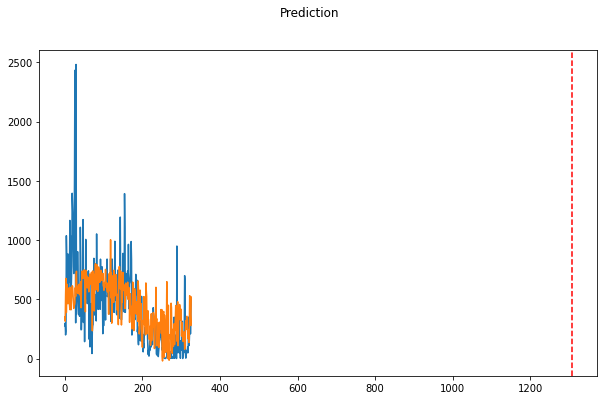

RMSE of validation set: 17.202517093207224
RMSE of entire data set: 6.196864060382096
_____STORE NUM. 2_____
Training Shape torch.Size([1191, 1, 19]) torch.Size([1191, 1])
Testing Shape torch.Size([297, 1, 19]) torch.Size([297, 1])
Validation Loss Decreased(inf--->0.01056) 	 Saving The Model
Validation Loss Decreased(0.01056--->0.00991) 	 Saving The Model
Validation Loss Decreased(0.00991--->0.00872) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00182 		 Validation Loss: 0.01288
Epoch 200 		 Training Loss: 0.00105 		 Validation Loss: 0.01339
Epoch 300 		 Training Loss: 0.00090 		 Validation Loss: 0.01312
Epoch 400 		 Training Loss: 0.00024 		 Validation Loss: 0.01206
Epoch 500 		 Training Loss: 0.00018 		 Validation Loss: 0.01196
Stopping the training early		Model saved
	Training Loss:  0.00032407467632194397
	Validation Loss:  0.00871600397460332
Shape of data_predict (297, 1)
Shape of dataY_plot (297, 1)


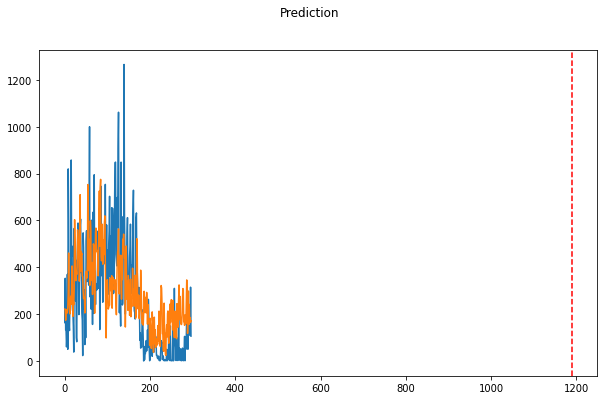

RMSE of validation set: 11.183009925840208
RMSE of entire data set: 5.628318297660836
_____STORE NUM. 3_____
Training Shape torch.Size([1287, 1, 19]) torch.Size([1287, 1])
Testing Shape torch.Size([321, 1, 19]) torch.Size([321, 1])
Validation Loss Decreased(inf--->0.01554) 	 Saving The Model
Validation Loss Decreased(0.01554--->0.01461) 	 Saving The Model
Validation Loss Decreased(0.01461--->0.01383) 	 Saving The Model
Validation Loss Decreased(0.01383--->0.01353) 	 Saving The Model
Validation Loss Decreased(0.01353--->0.01350) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00284 		 Validation Loss: 0.02077
Epoch 200 		 Training Loss: 0.00046 		 Validation Loss: 0.01962
Epoch 300 		 Training Loss: 0.00060 		 Validation Loss: 0.02762
Epoch 400 		 Training Loss: 0.00094 		 Validation Loss: 0.01795
Epoch 500 		 Training Loss: 0.00076 		 Validation Loss: 0.02045
Stopping the training early		Model saved
	Training Loss:  0.0002257988144265255
	Validation Loss:  0.013501023073964145
Shape o

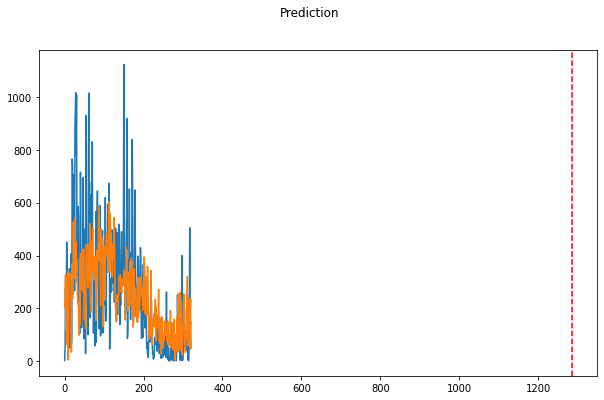

RMSE of validation set: 10.210121630857424
RMSE of entire data set: 4.60889314804483
_____STORE NUM. 4_____
Training Shape torch.Size([1313, 1, 19]) torch.Size([1313, 1])
Testing Shape torch.Size([328, 1, 19]) torch.Size([328, 1])
Validation Loss Decreased(inf--->0.01057) 	 Saving The Model
Validation Loss Decreased(0.01057--->0.01037) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00254 		 Validation Loss: 0.01424
Epoch 200 		 Training Loss: 0.00145 		 Validation Loss: 0.01359
Epoch 300 		 Training Loss: 0.00048 		 Validation Loss: 0.01432
Epoch 400 		 Training Loss: 0.00134 		 Validation Loss: 0.01472
Epoch 500 		 Training Loss: 0.00060 		 Validation Loss: 0.01516
Stopping the training early		Model saved
	Training Loss:  0.00045810500175340416
	Validation Loss:  0.010369220399297774
Shape of data_predict (328, 1)
Shape of dataY_plot (328, 1)


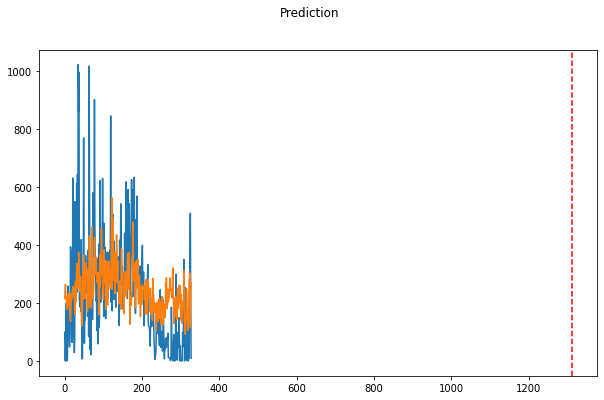

RMSE of validation set: 9.318105203055019
RMSE of entire data set: 4.356833427655519
_____STORE NUM. 5_____
Training Shape torch.Size([1261, 1, 19]) torch.Size([1261, 1])
Testing Shape torch.Size([314, 1, 19]) torch.Size([314, 1])
Validation Loss Decreased(inf--->0.01700) 	 Saving The Model
Validation Loss Decreased(0.01700--->0.01562) 	 Saving The Model
Validation Loss Decreased(0.01562--->0.01549) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00153 		 Validation Loss: 0.02523
Epoch 200 		 Training Loss: 0.00087 		 Validation Loss: 0.02554
Epoch 300 		 Training Loss: 0.00057 		 Validation Loss: 0.02440
Epoch 400 		 Training Loss: 0.00092 		 Validation Loss: 0.02400
Epoch 500 		 Training Loss: 0.00043 		 Validation Loss: 0.02233
Stopping the training early		Model saved
	Training Loss:  0.001014114899165149
	Validation Loss:  0.015490453740905808
Shape of data_predict (314, 1)
Shape of dataY_plot (314, 1)


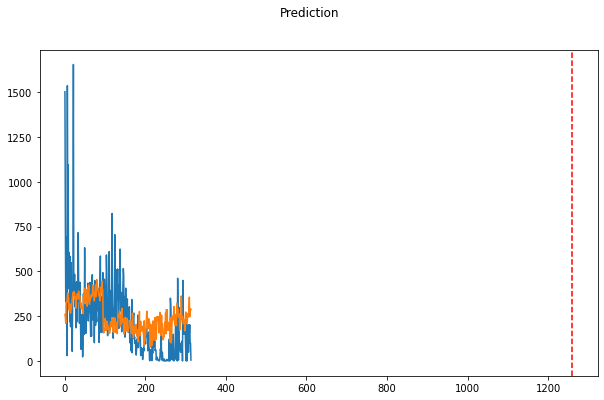

RMSE of validation set: 11.6695928746062
RMSE of entire data set: 4.43794487055292
_____STORE NUM. 6_____
Training Shape torch.Size([1317, 1, 19]) torch.Size([1317, 1])
Testing Shape torch.Size([329, 1, 19]) torch.Size([329, 1])
Validation Loss Decreased(inf--->0.00442) 	 Saving The Model
Validation Loss Decreased(0.00442--->0.00429) 	 Saving The Model
Validation Loss Decreased(0.00429--->0.00422) 	 Saving The Model
Validation Loss Decreased(0.00422--->0.00414) 	 Saving The Model
Validation Loss Decreased(0.00414--->0.00408) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00059 		 Validation Loss: 0.00708
Epoch 200 		 Training Loss: 0.00022 		 Validation Loss: 0.00526
Epoch 300 		 Training Loss: 0.00020 		 Validation Loss: 0.00519
Epoch 400 		 Training Loss: 0.00014 		 Validation Loss: 0.00504
Epoch 500 		 Training Loss: 0.00022 		 Validation Loss: 0.00584
Stopping the training early		Model saved
	Training Loss:  0.00016709371630464661
	Validation Loss:  0.004080091945676638
Shape of 

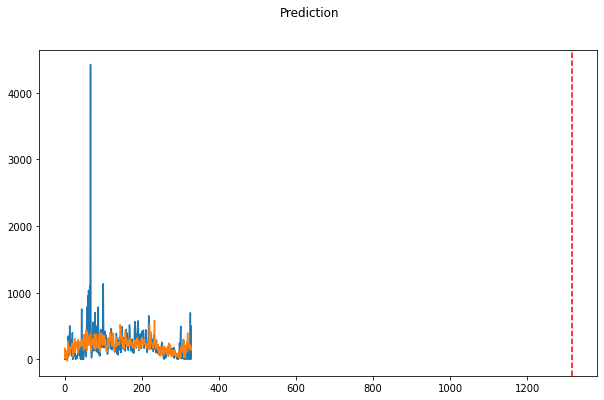

RMSE of validation set: 15.667846126245344
RMSE of entire data set: 4.77265270198388
_____STORE NUM. 7_____
Training Shape torch.Size([1281, 1, 19]) torch.Size([1281, 1])
Testing Shape torch.Size([320, 1, 19]) torch.Size([320, 1])
Validation Loss Decreased(inf--->0.01925) 	 Saving The Model
Validation Loss Decreased(0.01925--->0.01792) 	 Saving The Model
Validation Loss Decreased(0.01792--->0.01749) 	 Saving The Model
Validation Loss Decreased(0.01749--->0.01746) 	 Saving The Model
Validation Loss Decreased(0.01746--->0.01727) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00317 		 Validation Loss: 0.02382
Epoch 200 		 Training Loss: 0.00092 		 Validation Loss: 0.02575
Epoch 300 		 Training Loss: 0.00103 		 Validation Loss: 0.02436
Epoch 400 		 Training Loss: 0.00058 		 Validation Loss: 0.02878
Epoch 500 		 Training Loss: 0.00086 		 Validation Loss: 0.02601
Stopping the training early		Model saved
	Training Loss:  0.0004007665191475889
	Validation Loss:  0.01726824101364321
Shape of 

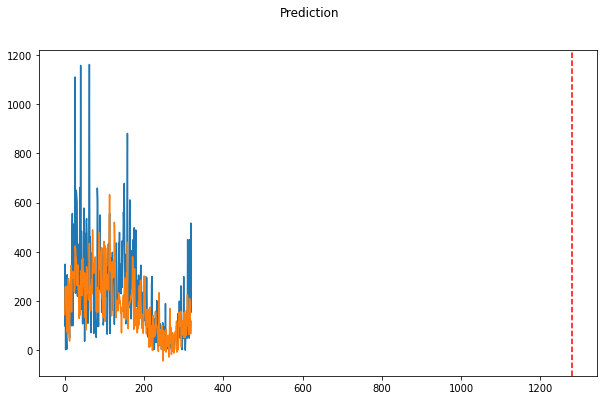

RMSE of validation set: 8.977143184340397
RMSE of entire data set: 4.358804538207378
_____STORE NUM. 8_____
Training Shape torch.Size([1161, 1, 19]) torch.Size([1161, 1])
Testing Shape torch.Size([289, 1, 19]) torch.Size([289, 1])
Validation Loss Decreased(inf--->0.01399) 	 Saving The Model
Validation Loss Decreased(0.01399--->0.01194) 	 Saving The Model
Validation Loss Decreased(0.01194--->0.01189) 	 Saving The Model
Validation Loss Decreased(0.01189--->0.01174) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00114 		 Validation Loss: 0.02580
Epoch 200 		 Training Loss: 0.00081 		 Validation Loss: 0.02223
Epoch 300 		 Training Loss: 0.00059 		 Validation Loss: 0.02193
Epoch 400 		 Training Loss: 0.00019 		 Validation Loss: 0.02041
Epoch 500 		 Training Loss: 0.00045 		 Validation Loss: 0.02566
Stopping the training early		Model saved
	Training Loss:  0.0007564950866220766
	Validation Loss:  0.011738776517588468
Shape of data_predict (289, 1)
Shape of dataY_plot (289, 1)


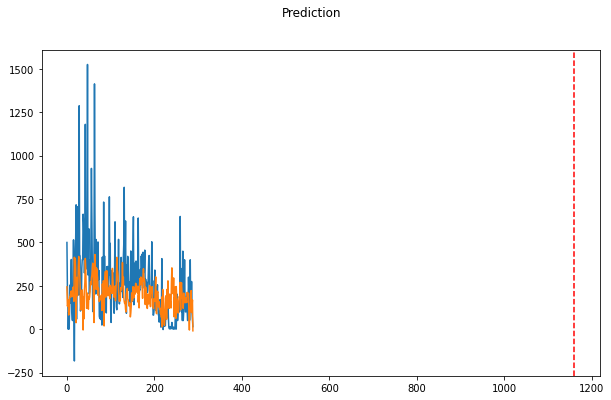

RMSE of validation set: 12.878214692734327
RMSE of entire data set: 4.734770885389666
_____STORE NUM. 9_____
Training Shape torch.Size([1254, 1, 19]) torch.Size([1254, 1])
Testing Shape torch.Size([313, 1, 19]) torch.Size([313, 1])
Validation Loss Decreased(inf--->0.01641) 	 Saving The Model
Validation Loss Decreased(0.01641--->0.01571) 	 Saving The Model
Validation Loss Decreased(0.01571--->0.01533) 	 Saving The Model
Validation Loss Decreased(0.01533--->0.01463) 	 Saving The Model
Validation Loss Decreased(0.01463--->0.01440) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00184 		 Validation Loss: 0.02073
Epoch 200 		 Training Loss: 0.00113 		 Validation Loss: 0.01991
Epoch 300 		 Training Loss: 0.00062 		 Validation Loss: 0.01983
Epoch 400 		 Training Loss: 0.00093 		 Validation Loss: 0.02030
Epoch 500 		 Training Loss: 0.00057 		 Validation Loss: 0.02149
Stopping the training early		Model saved
	Training Loss:  0.00047701265898972956
	Validation Loss:  0.014396352865530745
Shape 

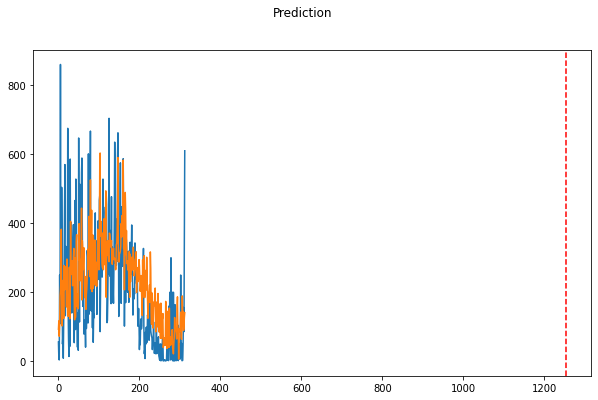

RMSE of validation set: 8.262761878490158
RMSE of entire data set: 2.8291678845238453
_____STORE NUM. 10_____
Training Shape torch.Size([1304, 1, 19]) torch.Size([1304, 1])
Testing Shape torch.Size([325, 1, 19]) torch.Size([325, 1])
Validation Loss Decreased(inf--->0.02783) 	 Saving The Model
Validation Loss Decreased(0.02783--->0.02274) 	 Saving The Model
Validation Loss Decreased(0.02274--->0.02170) 	 Saving The Model
Validation Loss Decreased(0.02170--->0.02131) 	 Saving The Model
Validation Loss Decreased(0.02131--->0.02092) 	 Saving The Model
Validation Loss Decreased(0.02092--->0.02088) 	 Saving The Model
Validation Loss Decreased(0.02088--->0.01974) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00438 		 Validation Loss: 0.03010
Epoch 200 		 Training Loss: 0.00243 		 Validation Loss: 0.04356
Epoch 300 		 Training Loss: 0.00050 		 Validation Loss: 0.03039
Epoch 400 		 Training Loss: 0.00163 		 Validation Loss: 0.02968
Epoch 500 		 Training Loss: 0.00076 		 Validation Loss: 0.03

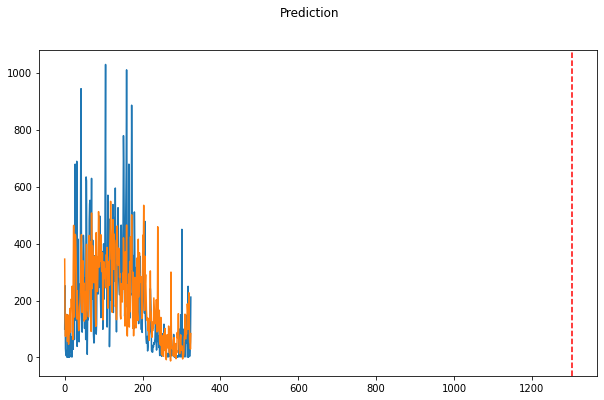

RMSE of validation set: 8.455124537362769
RMSE of entire data set: 3.4081590364333114
_____STORE NUM. 11_____
Training Shape torch.Size([1133, 1, 19]) torch.Size([1133, 1])
Testing Shape torch.Size([282, 1, 19]) torch.Size([282, 1])
Validation Loss Decreased(inf--->0.01983) 	 Saving The Model
Validation Loss Decreased(0.01983--->0.01608) 	 Saving The Model
Validation Loss Decreased(0.01608--->0.01499) 	 Saving The Model
Validation Loss Decreased(0.01499--->0.01475) 	 Saving The Model
Validation Loss Decreased(0.01475--->0.01466) 	 Saving The Model
Validation Loss Decreased(0.01466--->0.01464) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00221 		 Validation Loss: 0.02340
Epoch 200 		 Training Loss: 0.00066 		 Validation Loss: 0.02304
Epoch 300 		 Training Loss: 0.00023 		 Validation Loss: 0.02442
Epoch 400 		 Training Loss: 0.00018 		 Validation Loss: 0.02408
Epoch 500 		 Training Loss: 0.00050 		 Validation Loss: 0.02190
Stopping the training early		Model saved
	Training Loss:  0.0

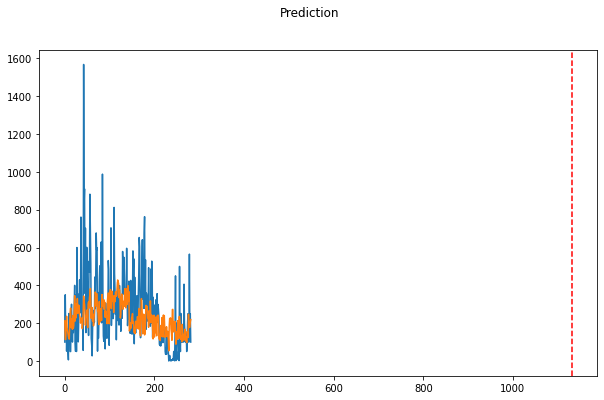

RMSE of validation set: 11.489730855856255
RMSE of entire data set: 4.878770552950655
_____STORE NUM. 12_____
Training Shape torch.Size([1326, 1, 19]) torch.Size([1326, 1])
Testing Shape torch.Size([331, 1, 19]) torch.Size([331, 1])
Validation Loss Decreased(inf--->0.01628) 	 Saving The Model
Validation Loss Decreased(0.01628--->0.01571) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00123 		 Validation Loss: 0.02984
Epoch 200 		 Training Loss: 0.00054 		 Validation Loss: 0.02373
Epoch 300 		 Training Loss: 0.00189 		 Validation Loss: 0.02201
Epoch 400 		 Training Loss: 0.00140 		 Validation Loss: 0.02919
Epoch 500 		 Training Loss: 0.00015 		 Validation Loss: 0.02170
Stopping the training early		Model saved
	Training Loss:  0.00014674238170157063
	Validation Loss:  0.015713499558235828
Shape of data_predict (331, 1)
Shape of dataY_plot (331, 1)


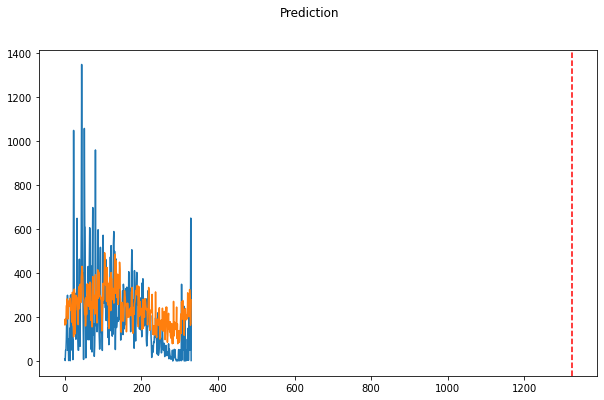

RMSE of validation set: 9.483823379336794
RMSE of entire data set: 4.023718225235591
_____STORE NUM. 13_____
Training Shape torch.Size([1247, 1, 19]) torch.Size([1247, 1])
Testing Shape torch.Size([311, 1, 19]) torch.Size([311, 1])
Validation Loss Decreased(inf--->0.01224) 	 Saving The Model
Validation Loss Decreased(0.01224--->0.01209) 	 Saving The Model
Validation Loss Decreased(0.01209--->0.01196) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00157 		 Validation Loss: 0.01671
Epoch 200 		 Training Loss: 0.00051 		 Validation Loss: 0.01711
Epoch 300 		 Training Loss: 0.00013 		 Validation Loss: 0.01711
Epoch 400 		 Training Loss: 0.00200 		 Validation Loss: 0.02360
Epoch 500 		 Training Loss: 0.00043 		 Validation Loss: 0.01672
Stopping the training early		Model saved
	Training Loss:  0.0006678117160239101
	Validation Loss:  0.011956628852361895
Shape of data_predict (311, 1)
Shape of dataY_plot (311, 1)


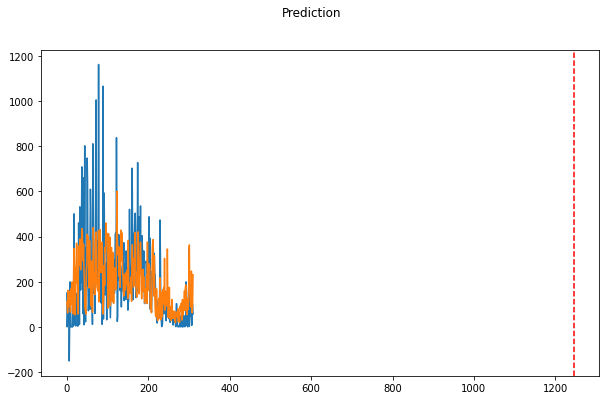

RMSE of validation set: 9.722808127909316
RMSE of entire data set: 3.916561844614245
_____STORE NUM. 14_____
Training Shape torch.Size([1261, 1, 19]) torch.Size([1261, 1])
Testing Shape torch.Size([314, 1, 19]) torch.Size([314, 1])
Validation Loss Decreased(inf--->0.01222) 	 Saving The Model
Validation Loss Decreased(0.01222--->0.01124) 	 Saving The Model
Validation Loss Decreased(0.01124--->0.01035) 	 Saving The Model
Validation Loss Decreased(0.01035--->0.01009) 	 Saving The Model
Validation Loss Decreased(0.01009--->0.00984) 	 Saving The Model
Validation Loss Decreased(0.00984--->0.00970) 	 Saving The Model
Validation Loss Decreased(0.00970--->0.00967) 	 Saving The Model
Validation Loss Decreased(0.00967--->0.00962) 	 Saving The Model
Validation Loss Decreased(0.00962--->0.00956) 	 Saving The Model
Validation Loss Decreased(0.00956--->0.00938) 	 Saving The Model
Validation Loss Decreased(0.00938--->0.00890) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00157 		 Validation Loss: 0

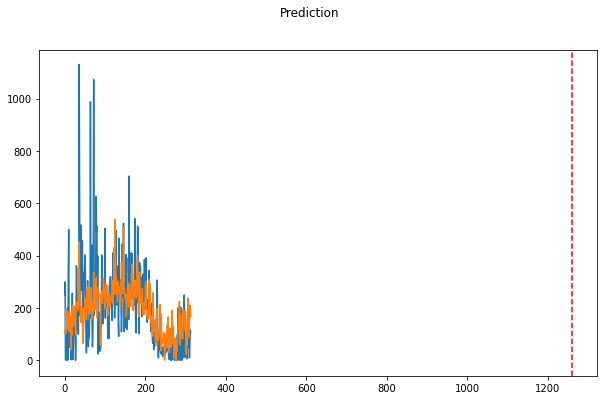

RMSE of validation set: 7.385419029825813
RMSE of entire data set: 2.769673580586791
_____STORE NUM. 15_____
Training Shape torch.Size([1275, 1, 19]) torch.Size([1275, 1])
Testing Shape torch.Size([318, 1, 19]) torch.Size([318, 1])
Validation Loss Decreased(inf--->0.01936) 	 Saving The Model
Validation Loss Decreased(0.01936--->0.01900) 	 Saving The Model
Validation Loss Decreased(0.01900--->0.01789) 	 Saving The Model
Validation Loss Decreased(0.01789--->0.01774) 	 Saving The Model
Validation Loss Decreased(0.01774--->0.01773) 	 Saving The Model
Validation Loss Decreased(0.01773--->0.01767) 	 Saving The Model
Validation Loss Decreased(0.01767--->0.01752) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00133 		 Validation Loss: 0.02874
Epoch 200 		 Training Loss: 0.00133 		 Validation Loss: 0.02635
Epoch 300 		 Training Loss: 0.00038 		 Validation Loss: 0.02370
Epoch 400 		 Training Loss: 0.00024 		 Validation Loss: 0.02261
Epoch 500 		 Training Loss: 0.00031 		 Validation Loss: 0.024

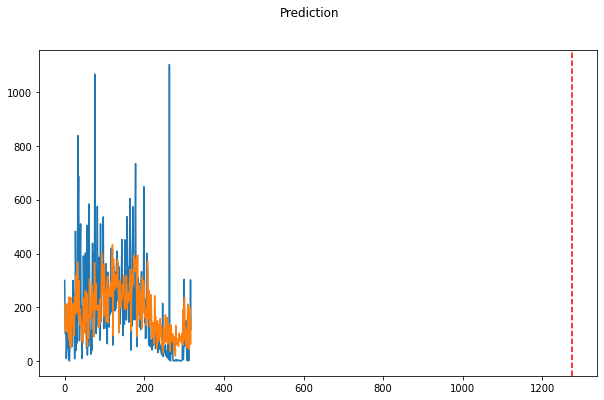

RMSE of validation set: 8.2011755021437
RMSE of entire data set: 3.1144313028583555
_____STORE NUM. 16_____
Training Shape torch.Size([1258, 1, 19]) torch.Size([1258, 1])
Testing Shape torch.Size([314, 1, 19]) torch.Size([314, 1])
Validation Loss Decreased(inf--->0.01833) 	 Saving The Model
Validation Loss Decreased(0.01833--->0.01727) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00134 		 Validation Loss: 0.02289
Epoch 200 		 Training Loss: 0.00043 		 Validation Loss: 0.02365
Epoch 300 		 Training Loss: 0.00109 		 Validation Loss: 0.02206
Epoch 400 		 Training Loss: 0.00016 		 Validation Loss: 0.02296
Epoch 500 		 Training Loss: 0.00043 		 Validation Loss: 0.02288
Stopping the training early		Model saved
	Training Loss:  9.325123355665709e-05
	Validation Loss:  0.01727202480011012
Shape of data_predict (314, 1)
Shape of dataY_plot (314, 1)


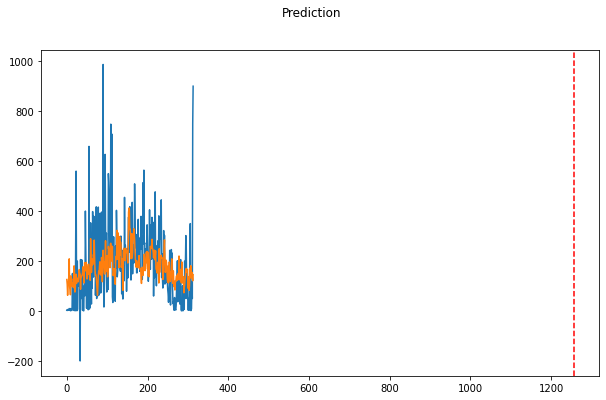

RMSE of validation set: 8.106145905422537
RMSE of entire data set: 3.2883030767791532
_____STORE NUM. 17_____
Training Shape torch.Size([1294, 1, 19]) torch.Size([1294, 1])
Testing Shape torch.Size([323, 1, 19]) torch.Size([323, 1])
Validation Loss Decreased(inf--->0.01208) 	 Saving The Model
Validation Loss Decreased(0.01208--->0.01186) 	 Saving The Model
Validation Loss Decreased(0.01186--->0.01161) 	 Saving The Model
Validation Loss Decreased(0.01161--->0.01158) 	 Saving The Model
Validation Loss Decreased(0.01158--->0.01138) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00059 		 Validation Loss: 0.01506
Epoch 200 		 Training Loss: 0.00070 		 Validation Loss: 0.01782
Epoch 300 		 Training Loss: 0.00072 		 Validation Loss: 0.01645
Epoch 400 		 Training Loss: 0.00025 		 Validation Loss: 0.01650
Epoch 500 		 Training Loss: 0.00008 		 Validation Loss: 0.01671
Stopping the training early		Model saved
	Training Loss:  0.0004007227828986542
	Validation Loss:  0.01138161182946836
Shape o

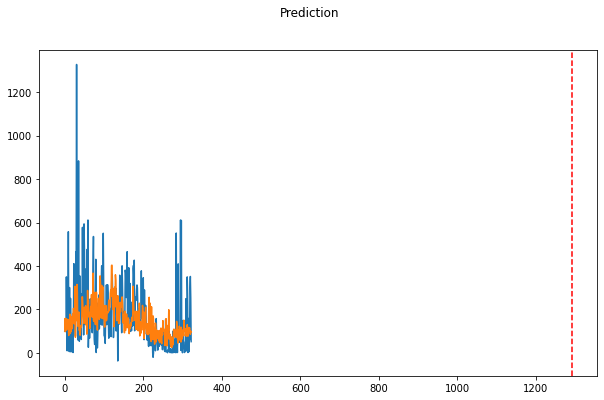

RMSE of validation set: 8.32164176416808
RMSE of entire data set: 3.5566518153993396
_____STORE NUM. 18_____
Training Shape torch.Size([1281, 1, 19]) torch.Size([1281, 1])
Testing Shape torch.Size([320, 1, 19]) torch.Size([320, 1])
Validation Loss Decreased(inf--->0.01196) 	 Saving The Model
Validation Loss Decreased(0.01196--->0.01124) 	 Saving The Model
Validation Loss Decreased(0.01124--->0.01035) 	 Saving The Model
Validation Loss Decreased(0.01035--->0.01008) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00148 		 Validation Loss: 0.01945
Epoch 200 		 Training Loss: 0.00230 		 Validation Loss: 0.01921
Epoch 300 		 Training Loss: 0.00068 		 Validation Loss: 0.02041
Epoch 400 		 Training Loss: 0.00034 		 Validation Loss: 0.01793
Epoch 500 		 Training Loss: 0.00071 		 Validation Loss: 0.02004
Stopping the training early		Model saved
	Training Loss:  0.00106385179558698
	Validation Loss:  0.010081358342532716
Shape of data_predict (320, 1)
Shape of dataY_plot (320, 1)


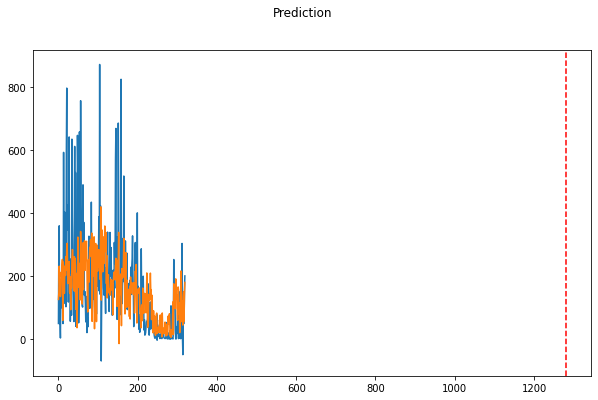

RMSE of validation set: 7.549827281387938
RMSE of entire data set: 3.4823029539954424
_____STORE NUM. 19_____
Training Shape torch.Size([1141, 1, 19]) torch.Size([1141, 1])
Testing Shape torch.Size([284, 1, 19]) torch.Size([284, 1])
Validation Loss Decreased(inf--->0.02473) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00207 		 Validation Loss: 0.03811
Epoch 200 		 Training Loss: 0.00055 		 Validation Loss: 0.03981
Epoch 300 		 Training Loss: 0.00103 		 Validation Loss: 0.03214
Epoch 400 		 Training Loss: 0.00042 		 Validation Loss: 0.03367
Epoch 500 		 Training Loss: 0.00041 		 Validation Loss: 0.03802
Stopping the training early		Model saved
	Training Loss:  0.0004610322590540419
	Validation Loss:  0.024725338033888312
Shape of data_predict (284, 1)
Shape of dataY_plot (284, 1)


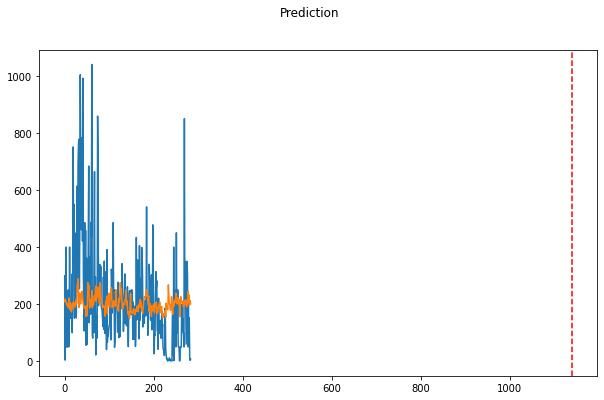

RMSE of validation set: 10.697256973251447
RMSE of entire data set: 4.014637767547951
_____STORE NUM. 20_____
Training Shape torch.Size([1174, 1, 19]) torch.Size([1174, 1])
Testing Shape torch.Size([293, 1, 19]) torch.Size([293, 1])
Validation Loss Decreased(inf--->0.01468) 	 Saving The Model
Validation Loss Decreased(0.01468--->0.01334) 	 Saving The Model
Validation Loss Decreased(0.01334--->0.01290) 	 Saving The Model
Validation Loss Decreased(0.01290--->0.01277) 	 Saving The Model
Validation Loss Decreased(0.01277--->0.01249) 	 Saving The Model
Validation Loss Decreased(0.01249--->0.01240) 	 Saving The Model
Epoch 100 		 Training Loss: 0.00173 		 Validation Loss: 0.01804
Epoch 200 		 Training Loss: 0.00070 		 Validation Loss: 0.01971
Epoch 300 		 Training Loss: 0.00092 		 Validation Loss: 0.01829
Epoch 400 		 Training Loss: 0.00053 		 Validation Loss: 0.01980
Epoch 500 		 Training Loss: 0.00057 		 Validation Loss: 0.01990
Stopping the training early		Model saved
	Training Loss:  0.0

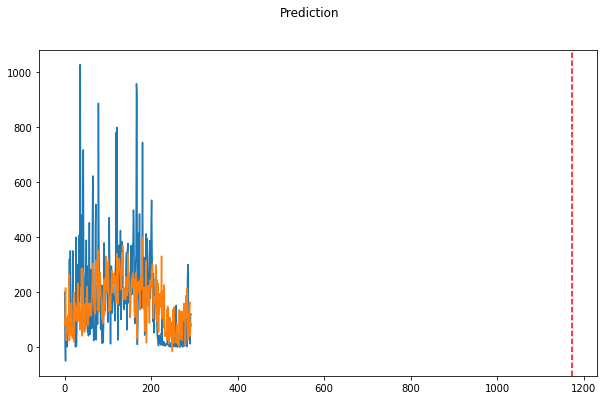

RMSE of validation set: 9.291780982154396
RMSE of entire data set: 3.550596135994887


In [459]:
for store in range(1,21):
    print("_____STORE NUM. {}_____".format(store))
    copy_dataset = final_data.copy()
    train_split = 0.8

    copy_dataset = copy_dataset[copy_dataset["SCRUB_STORE_NO"] == store]

    rows = int(train_split*copy_dataset.shape[0])

    X = copy_dataset.iloc[:, 3:99]
    y = copy_dataset.iloc[:, 0:1] 

    mm = MinMaxScaler()
    ss = StandardScaler()

    X_ss = ss.fit_transform(X)
    y_mm = mm.fit_transform(y)

    X_train = X_ss[:rows+1, :]
    X_test = X_ss[rows+1:, :]

    y_train = y_mm[:rows+1, :]
    y_test = y_mm[rows+1:, :] 

    data_X = Variable(torch.Tensor(X_ss))
    data_y = Variable(torch.Tensor(y_mm))

    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test)) 

    data_X_tensors = torch.reshape(data_X,   (data_X.shape[0], 1, data_X.shape[1]))
    X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
    X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

    print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
    print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

    X_train,y_train,X_val,y_val = X_train_tensors_final, y_train_tensors, X_test_tensors_final, y_test_tensors

    train_loader = dataloader(X_train,y_train,batch_size=14)
    valid_loader = dataloader(X_val,y_val,batch_size=14)

    num_epochs = 1000 #1000 epochs
    learning_rate = 3e-3 #0.001 lr

    input_size = 19 #number of features
    hidden_size = 40 #number of features in hidden state
    num_layers = 1 #number of stacked lstm layers

    num_classes = 1 #number of output classes

    lstm = LSTM1(num_classes, input_size, hidden_size, num_layers) #our lstm class 
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) 


    logger = Logger("./logs/model-1/training_log_store_{}.txt".format(store))
    PATH='./saved-models/model-1/saved_model_store_{}.pth'.format(store)

    min_valid_loss = np.inf
    current_threshold = 0
    cutoff_threshold = num_epochs/2

    for epoch in range(num_epochs):
        '''---training---'''
        train_loss = 0.0
        lstm.train()

        for i in train_loader:
            data = i["data"]
            output = i["output"]

            outputs = lstm(data)
            optimizer.zero_grad()

            # obtain the loss function
            loss = criterion(outputs, output)

            loss.backward()

            optimizer.step()

            train_loss += loss.item()

        train_loss = train_loss / len(train_loader)

        '''---validation---'''
        valid_loss = 0.0
        lstm.eval() 

        for i in valid_loader:
            val_input = i["data"]
            val_output = i["output"]

            outputs = lstm(val_input)

            loss = criterion(outputs,val_output)

            valid_loss += loss.item()

        valid_loss = valid_loss / len(valid_loader)

        if (epoch + 1) % 100 == 0:
            print('Epoch %d \t\t Training Loss: %1.5f \t\t Validation Loss: %1.5f'%(epoch+1,train_loss,valid_loss))
            logger.log('Epoch %d \t\t Training Loss: %1.5f \t\t Validation Loss: %1.5f'%(epoch+1,train_loss,valid_loss))

        if min_valid_loss > valid_loss:
            current_threshold = 0
            print(f'Validation Loss Decreased({min_valid_loss:1.5f}--->{valid_loss:1.5f}) \t Saving The Model')
            logger.log(f'Validation Loss Decreased({min_valid_loss:1.5f}--->{valid_loss:1.5f}) \t Saving The Model')
            min_valid_loss = valid_loss

            # Saving State Dict
            torch.save(lstm.state_dict(), PATH)
        else:
            current_threshold += 1

            if current_threshold == cutoff_threshold:
                print("Stopping the training early\t\tModel saved")
                print("\tTraining Loss: ",train_loss)
                print("\tValidation Loss: ",min_valid_loss)

                logger.log("Stopping the training early\t\tModel saved")
                logger.log("\tTraining Loss: {}".format(train_loss))
                logger.log("\tValidation Loss: {}".format(min_valid_loss))
                logger.log("\n\n\n")

                break



    lstm = LSTM1(num_classes, input_size, hidden_size, num_layers)
    lstm.load_state_dict(torch.load(PATH))
    lstm.eval()


    train_predict = lstm(X_val)

    data_predict = train_predict.data.numpy()
    dataY_plot = y_val.data.numpy()

    print("Shape of data_predict {}".format(data_predict.shape))
    print("Shape of dataY_plot {}".format(dataY_plot.shape))

    data_predict = mm.inverse_transform(data_predict)
    dataY_plot = mm.inverse_transform(dataY_plot)

    plt.figure(figsize=(10,6))

    plt.axvline(x=rows, c='r', linestyle='--')

    plt.plot(dataY_plot)
    plt.plot(data_predict)
    plt.suptitle('Prediction')
    plt.show()

    print("RMSE of validation set: {}".format(RMSE(data_predict,dataY_plot)))
    logger.log("RMSE of validation set: {}".format(RMSE(data_predict,dataY_plot)))

    train_predict = lstm(data_X_tensors)

    data_predict = train_predict.data.numpy()
    dataY_plot = data_y.data.numpy()

    data_predict = mm.inverse_transform(data_predict)
    dataY_plot = mm.inverse_transform(dataY_plot)

    print("RMSE of entire data set: {}".format(RMSE(data_predict,dataY_plot)))
    logger.log("RMSE of entire data set: {}".format(RMSE(data_predict,dataY_plot)))

    logger.log("\n\n\n")
    logger.stop()

In [464]:
final_data

,SALES_UNITS,DATE_VALID_STD,SCRUB_STORE_NO,TIME_DIM_KEY,DOY_STD,AVG_TEMPERATURE_AIR_2M_F,AVG_TEMPERATURE_WETBULB_2M_F,AVG_TEMPERATURE_DEWPOINT_2M_F,AVG_TEMPERATURE_FEELSLIKE_2M_F,AVG_HUMIDITY_RELATIVE_2M_PCT,...,AVG_PRESSURE_MEAN_SEA_LEVEL_MB,AVG_WIND_SPEED_10M_MPH,AVG_WIND_DIRECTION_10M_DEG,AVG_WIND_DIRECTION_80M_DEG,AVG_WIND_DIRECTION_100M_DEG,TOT_PRECIPITATION_IN,TOT_SNOWFALL_IN,AVG_CLOUD_COVER_TOT_PCT,AVG_RADIATION_SOLAR_TOTAL_WPM2,TOT_RADIATION_SOLAR_TOTAL_WPM2
0,759,2016-01-02,1,20160102,2,4.0,3.4,2.8,2.7,-4.0,...,-3.9,2.3,2,-5,-6,-0.12,-0.88,-30,-14.9,-356.6
1,486,2016-01-03,1,20160103,3,3.0,2.2,0.9,2.4,-7.0,...,1.6,0.9,80,72,73,-0.12,-0.76,7,1.9,46.3
2,326,2016-01-04,1,20160104,4,-6.6,-6.9,-8.6,-6.2,-7.0,...,13.6,-2.2,-224,-231,-229,-0.12,-0.75,-37,45.1,1083.9
3,395,2016-01-05,1,20160105,5,-6.5,-6.5,-6.6,-8.8,-1.4,...,13.6,0.6,-79,-78,-76,-0.12,-0.87,-6,4.1,97.2
4,478,2016-01-06,1,20160106,6,4.4,3.7,2.9,4.9,-5.0,...,6.8,-0.7,-65,-73,-72,-0.13,-0.88,-24,31.0,745.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31316,100,2021-08-29,20,20210829,241,0.6,3.4,5.5,0.9,11.2,...,3.7,-0.5,-135,-164,-136,-0.44,0.00,54,-122.5,-2940.7
31317,100,2021-09-04,20,20210904,247,-5.6,-4.5,-3.8,-6.0,3.2,...,-0.6,-0.8,-30,-18,-21,-0.44,0.00,0,38.1,914.8
31318,12,2021-09-05,20,20210905,248,-3.5,0.8,3.7,-4.2,17.9,...,-6.0,0.0,-59,-92,-88,-0.34,0.00,48,-157.1,-3768.2
31319,120,2021-09-06,20,20210906,249,1.7,1.4,1.6,1.5,-1.1,...,-6.0,1.9,-8,-21,-18,-0.41,0.00,-4,20.7,497.4


In [479]:
training_copy = final_data.copy()
forecasting_copy = forecast_dataset.copy()

In [490]:
temp = list(training_copy.columns)
cols = list()

for i in temp:
    if i != "SALES_UNITS":
        cols.append(i)

In [491]:
temp = forecasting_copy.copy()

rows = forecasting_copy.shape[0]
vals = list()

for i in range(rows):
    s = "".join(str(temp["DATE_VALID_STD"][i]).split()[0].split("-"))
    
    vals.append(s)

forecasting_copy["TIME_DIM_KEY"] = vals

In [492]:
forecasting_copy = forecasting_copy[cols]

In [511]:
training_copy.to_csv("./datasets/training.csv",index=False)
forecasting_copy.to_csv("./datasets/forecasting.csv",index=False)